# Running a wavelet computation on a $CH_4$ molecule, with AiiDa

This is a copy of the CH4 tutorial, please check the CH4 tutorial first for details about computations and datasets.
The purpose of this tutorial is to outline the integration of AiiDa with BigDFT workflows and datasets. This allows jobs to be offloaded to remote supercomputers and database storage of computed results, as well as transparent integration with PyBigDFT analysis tools.

## Introduction: AiiDa installation

AiiDa must be functional on your system for this tutorial. Please install the prerequisites from [here](https://aiida.readthedocs.io/projects/aiida-core/en/latest/install/prerequisites.html), follow the steps from the guide [here](https://aiida-core.readthedocs.io/en/latest/install/installation.html) to setup the latest version of AiiDA, and take some time to familiarize with this environment and verdi command line tools.

This tutorial should be run from Aiida's python virtual environment. Jupyter should also be setup in a way that either "import aiida", "%aiida", or with a compatible aiida-aware kernel. Check [this page](https://aiida-core.readthedocs.io/en/latest/install/configuration.html#using-aiida-in-jupyter) for details.

Once aiida is installed, you need to install the BigDFT plugin, with 'pip install aiida-bigdft', or locally, using the one available on https://github.com/aiidateam/aiida-bigdft-plugin.

Once installed, you need to start the verdi daemon with PyBigDFT's path in the PYTHONPATH. If BigDFT is installed locally, this can be done by executing 'source BIGDFT_INSTALL_PATH/bin/bigdftvars.sh' before running. 

If BigDFT is not installed locally, you may need to execute 'export PYTHONPATH=BIGDFT_SOURCE_PATH/PyBigDFT/:BIGDFT_SOURCE_PATH/futile/src/python'

Next you need to setup machines and codes you will use.
In this tutorial we will use a 'localhost' machine, without scheduler. BigDFT needs to be installed on the machine.

### Aiida setup for the tutorial

#### Computer
`verdi computer setup`

then enter
- Computer label: localhost
- Hostname: localhost
- Description []: 
- Transport plugin: local
- Scheduler plugin: direct
- Shebang line (first line of each script, starting with #!) [#!/bin/bash]: 
- Work directory on the computer [/scratch/{username}/aiida/]: path/to/a/folder/to/store/aiida/generated/files
- Mpirun command [mpirun -np {tot_num_mpiprocs}]: 
- Default number of CPUs per machine: number of cores of your computer (or less)
Then, no need for a specific script, just hit escape and then :wq to exit.
              
Once this is done, just launch

`verdi computer configure local localhost`

and keep the default setting to allow usage of the computer. 


#### Code

`verdi code setup`

- Label: bigdft
- Description []: bigdft on localhost
- Default calculation input plugin: bigdft
- Installed on target computer? [True]:    
- Computer: localhost
- Remote absolute path: /path/to/bigdft/install/bin/bigdft

And in the "pre execution script" section, add 

`source /path/to/bigdft/install/bin/bigdftvars.sh`


In [1]:
#prepare computation the same way as in normal computation:
inp = { 'dft': { 'hgrids': 0.55, 'rmult': [3.5, 9.0]} }
# becomes
from BigDFT import Inputfiles as I
inp=I.Inputfile()
inp.set_hgrid(0.55)
inp.set_rmult([3.5,9.0])

In [2]:
inp.set_atomic_positions('CH4_posinp.xyz')

A simple calculation can now be run on the selected platform using an AiidaCalculator instead of SystemCalculator.
- code is a mandatory option, to select the code and the target computer
- num_machines, mpiprocs_per_machine, omp (number of OpenMP threads per MPI process), walltime are optional parameters 

In [ ]:
%aiida
from BigDFT import AiidaCalculator as calc
reload(calc)
study = calc.AiidaCalculator(code="bigdft@localhost", 
                             num_machines=1, 
                             mpiprocs_per_machine=1, 
                             omp=1,
                             walltime=3600) #Create a calculator
ch4 = study.run(input=inp)

*ch4* is the instance of the class Logfile which can handle easily all information coming from the output file **log.yaml**.
Then we can display some information as:

In [4]:
print ch4

- Atom types:
  - C
  - H
- cell: Free BC
- forcemax_cv: 0.0
- symmetry: disabled
- energy: -8.025741170832761
- grid_spacing: 0.55
- XC_parameter: 1
- nat: 5
- forcemax: 0.02215090866814
- dipole:
  - -0.004290608
  - -0.004290608
  - -0.004290608
- spin_polarization: 1
- system_charge: 0
- number_of_orbitals: 4
- rmult:
  - 3.5
  - 9.0
- fermi_level: -0.341339593821
- posinp_file: CH4_posinp.xyz
- total_magn_moment: 0
- gnrm_cv: 0.0001
- No. of KS orbitals:
  - 4



# Construction of the input dataset dictionaries
As in plain BigDFT notebook, you can group computations in Datasets.
Aiida's main feature in this case is the possibility to launch all the computations from the dataset asynchronously, creating and tracking multiple parallel jobs to execute on the target computer.

metadata can be assigned to Datasets to tune runtime parameters or scheduler options for all internal computation tasks.

Let us build two different dataset of inputfiles, the first one synchronous, the other asynchronous.
We also label each of the input dictionaries by a unique name identifying the run.

In [5]:
from BigDFT import Datasets as D
import copy
hgrids = [ 0.55 - i*0.05 for i in range(8)]
crmult = [ 3.5 + i*0.5 for i in range(8)]

In [6]:
metadata={
    #'queue_name':'my_queue', 
    #'account':'my_account', 
    #'qos':'myqos'
}
h_only_dataset=D.Dataset('h_only',run_dir=".",metadata=metadata)
for h in hgrids:
    inp_run=copy.deepcopy(inp)
    inp_run['dft']['hgrids'] = h
    label_run='h='+str(h)
    h_only_dataset.append_run(id={'h':h} , runner=study , input=inp_run)

In [7]:
c_only_dataset=D.Dataset('c_only',run_dir=".", async=True,metadata=metadata)
for c in crmult:
    inp_run=copy.deepcopy(inp)
    inp_run['dft']['rmult'] = [c,9.0] #only change crmult
    label_run='c='+str(c)
    c_only_dataset.append_run(id={'c':c} , runner=study , input=inp_run)

In [8]:
h_and_c_dataset=D.Dataset('h_and_c',run_dir=".", async=True,metadata=metadata)
for h,c in zip(hgrids,crmult):
    inp_run=copy.deepcopy(inp)
    inp_run['dft']['hgrids'] = h
    inp_run['dft']['rmult'] = [c,9.0] #only change crmult
    h_and_c_dataset.append_run(id={'h':h,'c':c} , runner=study , input=inp_run)

We then run the first dataset synchronously, one job at a time, which will block us a while:

In [ ]:
h_only_dataset.run()
h_only_results = h_only_dataset.results

Launch  the second and third datasets asynchronously.

- WARNING : if you are running locally, this will launch several instances of bigdft at the same time, which could use a lot of memory. 


In [ ]:
c_only_dataset.run()

In [ ]:
h_and_c_dataset.run()

As the dataset has been launched asynchronously, we now must wait for the end of execution, and gather the results (we can do other work while the dataset is running).
The wait() call is an optional commodity which will return only when AiiDa reports that no process from the dataset is running anymore, allowing to postprocess the data.
- Hint : use jupyter-notify to get a notification in your browser when a cell finishes : pip install jupyternotify, then uncomment next cell and the %notify magic which activates it for a given cell.

In [12]:
#%load_ext jupyternotify

In [13]:
#%notify
c_only_dataset.wait()
h_and_c_dataset.wait()

'0 processes still running'

Aiida retrieves logfiles and other output files from BigDFT automatically. To load them in this notebook, get_logfiles() can be used

In [ ]:
c_only_results=c_only_dataset.get_logfiles()
h_and_c_results=h_and_c_dataset.get_logfiles()

We now store the energies of each of the dataset runs, and identify the minimum as the minimum value from the `h_and_c` dataset:

In [15]:
import matplotlib.pyplot as plt
import numpy as np
energies_h=np.array([h_only_results[c].energy for c in h_only_results])
energies_c=np.array([c_only_results[c].energy for c in c_only_results])
energies_hc=np.array([h_and_c_results[c].energy for c in h_and_c_results])
#find the minimum
emin=np.min(energies_hc)

We plot the energy values varying the grid spacing or the extension

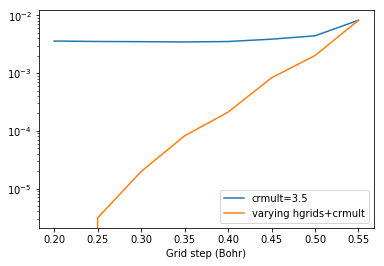

In [16]:
%matplotlib inline
plt.xlabel('Grid step (Bohr)')
plt.plot(hgrids,energies_h-emin,label='crmult=3.5')
plt.plot(hgrids,energies_hc-emin,label='varying hgrids+crmult')
plt.yscale('log')
plt.legend(loc='best')

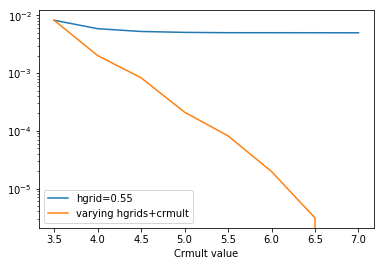

In [18]:
plt.xlabel('Crmult value')
plt.plot(crmult,energies_c-emin,label='hgrid=0.55')
plt.plot(crmult,energies_hc-emin,label='varying hgrids+crmult')
plt.yscale('log')
plt.legend(loc='best')

And we can the analyze results exactly as in a non-AiiDa notebook